## Investment Thesis



Evaluation of whether the Ames Housing Market presents an attractive investment opportunity and which features to be considered when attempting real estate arbitrage.

- note: valuation

In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from xgboost import XGBRegressor

import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_boxcox = pd.read_csv("datasets/train_boxcox.csv")
id_ = train_boxcox["id"]
train_eng = pd.read_csv("datasets/train_engineered.csv")
y = train_eng["saleprice"]

In [3]:
train_boxcox.drop(["Unnamed: 0", "id"], axis = 1, inplace = True)

In [4]:
def get_impt_features(models, x, y):
    
    '''gets feature importances/ coefficients of models'''
    
    x_train, x_val, y_train, y_val = train_test_split(x, np.log(y), random_state = 42)
    
    rs = RobustScaler()
    x_train_rs = rs.fit_transform(x_train)
    x_val_rs = rs.transform(x_val)
    
    results = pd.DataFrame()
    
    for name, model in models.items():
        model.fit(x_train_rs, y_train)
        
        try:
            importances = np.exp(model.coef_)
            df_features = (
                        pd.DataFrame(
                            zip(x_train.columns, importances),
                            columns=[name, f"{name} Importance"],
                      )
                        .sort_values(f"{name} Importance", ascending=False)
                        .reset_index(drop=True)
                    )
            results = pd.concat([results, df_features], axis=1)

        except:
            pass
        
        try:
            importances = np.exp(model.feature_importances_)
            df_features = (
                        pd.DataFrame(
                            zip(x_train.columns, importances),
                            columns=[name, f"{name} Importance"],
                      )
                        .sort_values(f"{name} Importance", ascending=False)
                        .reset_index(drop=True)
                    )
            results = pd.concat([results, df_features], axis=1)

        except:
            pass
        
    
    for name, model in models.items():
        if name == "XGBR":
            y_train_pred = xgbr.predict(x_train_rs)
            y_val_pred = xgbr.predict(x_val_rs)
            
            train = np.vstack((rs.inverse_transform(x_train_rs), rs.inverse_transform(x_val_rs)))
            
            data = pd.DataFrame(train, columns = x.columns)
            
            data["saleprice_predicted"] = np.hstack((np.exp(y_train_pred), np.exp(y_val_pred)))
            data["saleprice"] = np.hstack((np.exp(y_train), np.exp(y_val)))
            
            return results, data, xgbr

In [5]:
ridge_best = Ridge(alpha= 3.5, max_iter= 10000000.0, random_state= 42)
lasso_best = Lasso(alpha= 0.0002, max_iter= 10000000.0, random_state= 42)
xgbr = XGBRegressor(gamma = 0.0, learning_rate = 0.1, max_depth = None, random_state = 42, reg_alpha = 1e-06)

#returns feature importances + dataset with saleprice & predicted saleprice
importances, dataset, xgbr = get_impt_features({"Ridge": ridge_best, "Lasso": lasso_best, "XGBR": xgbr}, train_boxcox, y)

In [6]:
def barplotter(df, x_name, y_name, n):
    
    '''takes in input dataframe, name of x column, name of y column, and number of rows.
    returns barchart.'''

    bar = sns.catplot(x = x_name,
                          y = y_name,
                          data = df.head(n),
                          kind = 'bar',
                          height = 8,
                          aspect = 2,
                          palette = "icefire"
                     )

    plt.title('Coefficients', fontsize = 24)
    plt.xlabel("Coefficients", size = 20)
    plt.ylabel("Features", size = 20)
    plt.show()
       

# Predicted vs Actual: Graph

In [7]:
#actual vs predicted

def arranger(df, col):
    
    df = df.sort_values(col)
    df = df.reset_index()
    
    for i in range(len(df)):
        df["index"].iloc[i] = i
    
    return df

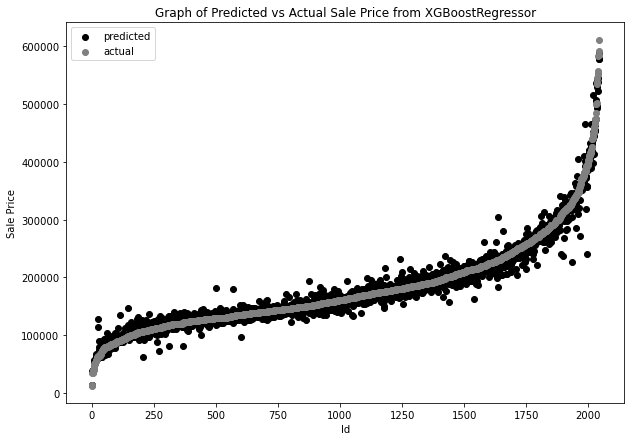

In [8]:
arranged = arranger(dataset, "saleprice")
plt.figure(figsize = (10,7))
plt.scatter(arranged["index"], arranged["saleprice_predicted"], color="black")
plt.scatter(arranged["index"], arranged["saleprice"], color="grey")
plt.legend(["predicted", "actual"])
plt.title("Graph of Predicted vs Actual Sale Price from XGBoostRegressor")
plt.xlabel("Id")
plt.ylabel("Sale Price")
plt.show()

Predicted prices were quite effective in capturing the extremes in the dataset, making XGBRegressor a suitable model for valuation.

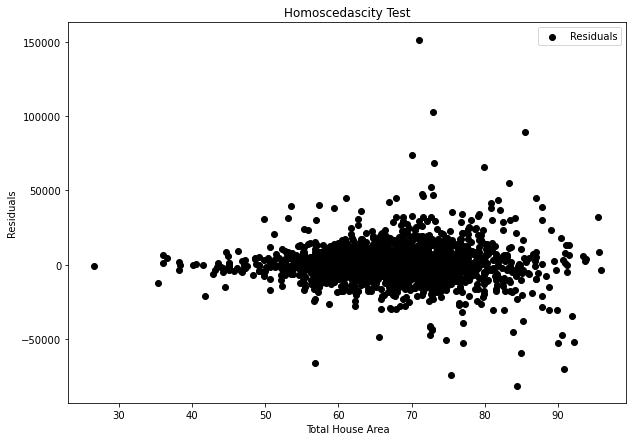

In [9]:
#homoscedascity check

arranged["residuals"] = arranged["saleprice"] - arranged["saleprice_predicted"]
arranged = arranger(arranged, "total_house_area")
plt.figure(figsize = (10,7))
plt.scatter(arranged["total_house_area"], arranged["residuals"], color="black")
#plt.scatter(arranged["index"], arranged["saleprice"], color="grey")
plt.legend(["Residuals"])
plt.title("Homoscedascity Test")
plt.xlabel("Total House Area")
plt.ylabel("Residuals")
plt.show()

Heteroscedascity.

# Valuation

## Feature Importances

Although other models had a higher accuracy, the features extracted from XGBoostRegressor had the most commercial value and will be used to identify potentially undervalued or overvalued properties for real estate arbitrage.

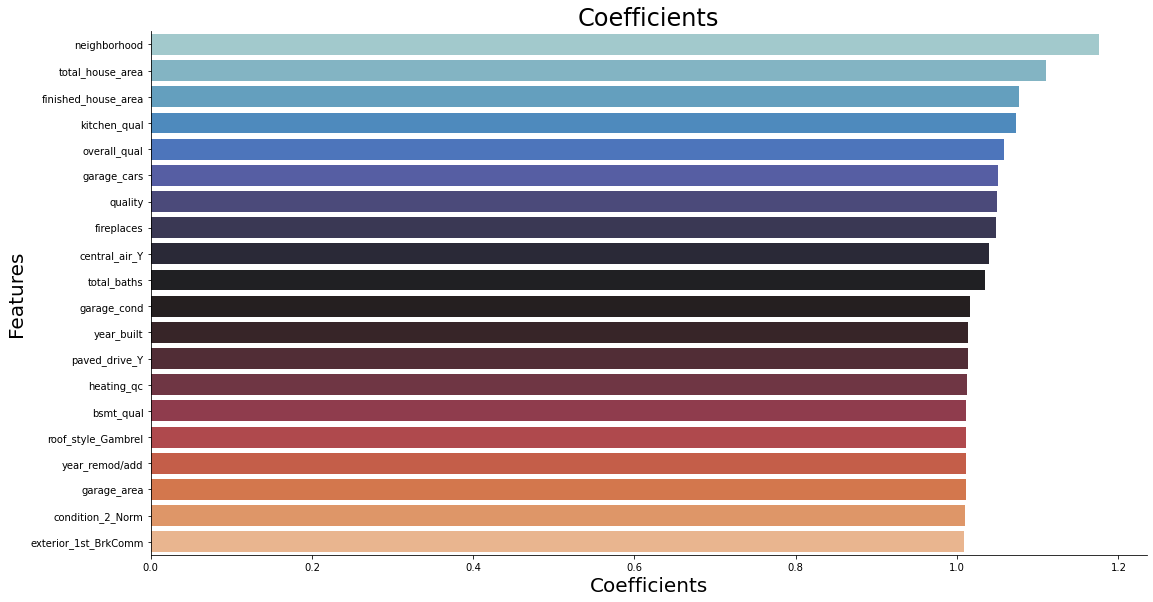

In [10]:
barplotter(importances, "XGBR Importance", "XGBR", 20)

From the graph, the features which appear to be most salient are the neighborhood, total house area, finished house area, and ktichen quality. Fireplaces, total baths, heating quality, and basement quality also appear to have moderate predictive value.

## Automated Valuation

In [11]:
train = pd.read_csv("datasets/train_cleaned.csv")
train_num = train.select_dtypes(include=[np.number])

In [12]:
def boxcox(df, df_ref):
    
    '''boxcox transforms numerical columns with a skew > 0.5 for skew reduction'''
    
  
    df_skew = pd.DataFrame(df_ref.skew())
    highskew = df_skew[df_skew > 0.5]
    highskew.dropna(inplace = True)
    
    #only use boxcox on columns with high skew for skew reduction
    for col in highskew.index:
        if col != "id" and col in df.columns:
            df[col] = boxcox1p(df[col], boxcox_normmax(df[col] + 1))
            
    return df



#average profit from upgrading the kitchen



def valuator(values):
    
    '''values will be in a 2d array or dataframe format. Valuator shows predicted values according to model.'''
    
    train_boxcox.rename({"neighborhood": "nb_cluster"}, inplace = True)
    
    x_train, x_val, y_train, y_val = train_test_split(train_boxcox, np.log(y), random_state = 42, shuffle = False)
    
    #RobustScaler to re-learn the parameters for the train dataset
    rs = RobustScaler()
    x_train_rs = rs.fit_transform(x_train)
    
    saleprices = values["saleprice"].copy()
    
    values_df = values.copy()
    
    for col in ["saleprice", "nb_name"]:
        try:
            values_df.drop(col, axis = 1, inplace = True)
        except:
            pass    
    
    #boxcox transform
    boxcox_values = boxcox(values_df, train_num)
    
    #robust scaler transform 
    
    prices = xgbr.predict(rs.transform(boxcox_values))
    
    #before/after comparison
    
    valued = pd.DataFrame(values_df, columns = values.columns)
    valued["Before"] = saleprices
    valued["After"] = np.exp(prices)
    
    return valued

In [13]:
def preprocessing(df, purpose = "analysis"):
    
    '''Extracts & merges the neighborhood names column for analysis.
    Filters most important features'''
    
    df["id"] = id_
    
    train_cleaned = pd.read_csv("datasets/train_cleaned.csv")
    train_cleaned.drop([328, 616, 960, 1147, 1885, 858, 761], axis = 0, inplace = True)
    nbs = train_cleaned.filter(["id", "neighborhood"])
    
    df = df.merge(nbs, on = "id", how = "right")
    
    for col in ["Unnamed: 0", "Unnamed: 0.1", "id"]:
        try:
            df.drop(columns = col, axis = 1, inplace = True)
        except KeyError:
            pass
   
    df.rename(columns = {"neighborhood_x": "nb_cluster", "neighborhood_y": "nb_name"}, inplace = True)
    df = df.reindex(sorted(df.columns), axis=1)
    
    impt = importances.head(20)
    impt = impt["XGBR"].values
    
    cols = set(impt) - set("neighborhood")
    cols.update({"nb_cluster", "nb_name", "finished_house_area"})
    
    if purpose == "analysis":
    
        df = df.filter(cols)
        df["saleprice"] = y

        return df
    
    else:
        df["saleprice"] = y
        return df

In [14]:
#using pre-transformed data (without boxcox transformation or robust scaling)
no_boxcox_feat = preprocessing(train_eng, "analysis")
no_boxcox = preprocessing(train_eng, "valuation")

### Neighborhoods

In [15]:
nb_cluster_3 = no_boxcox_feat[no_boxcox_feat["nb_cluster"] == 3]
pd.set_option('display.max_columns', None)
nb_cluster_3.groupby("nb_name").mean()

,total_baths,total_house_area,garage_area,central_air_Y,nb_cluster,garage_cond,heating_qc,roof_style_Gambrel,condition_2_Norm,garage_cars,year_remod/add,paved_drive_Y,finished_house_area,bsmt_qual,kitchen_qual,exterior_1st_BrkComm,overall_qual,year_built,fireplaces,quality,saleprice
nb_name,,,,,,,,,,,,,,,,,,,,,
Blmngtn,2.295455,2752.681818,492.636364,1.000000,3.0,3.000000,5.000000,0.000000,1.000000,2.318182,2005.545455,1.000000,1750.863636,4.090909,4.045455,0.000000,7.181818,2005.090909,0.954545,5.565625,200417.681818
ClearCr,2.518519,2982.259259,488.296296,1.000000,3.0,3.000000,4.222222,0.000000,1.000000,1.740741,1983.259259,0.962963,2338.074074,3.691358,3.518519,0.000000,6.037037,1968.592593,1.407407,4.972647,217490.074074
CollgCr,2.500000,2662.788889,567.005556,1.000000,3.0,2.994444,4.766667,0.000000,1.000000,2.066667,1999.616667,1.000000,1996.894444,3.977778,3.838889,0.000000,6.683333,1998.422222,0.405556,5.353395,202497.216667
Crawfor,2.169014,2748.760563,423.380282,0.929577,3.0,2.957746,4.042254,0.028169,1.000000,1.661972,1980.704225,0.887324,2174.126761,3.464789,3.521127,0.014085,6.253521,1947.704225,1.197183,5.231020,205901.211268
NWAmes,2.603448,2963.057471,541.793103,1.000000,3.0,3.011494,3.666667,0.000000,0.977011,2.022989,1981.643678,1.000000,2289.586207,3.574713,3.413793,0.000000,6.390805,1976.298851,0.919540,5.105109,194619.022989
Somerst,2.657692,2758.492308,615.515385,1.000000,3.0,3.000000,4.938462,0.000000,0.992308,2.238462,2005.069231,1.000000,1952.561538,4.161538,4.061538,0.000000,7.430769,2004.753846,0.515385,5.608580,227183.900000


When comparing Tier 3 neighborhoods, NWAmes and ClearCr had a bigger total house area than the rest, but the average sales price for NWAmes is 194k and well below the average of other Tier 3 neighborhoods. There may be arbitrage opportunities present in NWAmes, especially if you upgrade the kitchen and heating quality (among the top 20 highest predictors).

In [16]:
#average profit from upgrading the kitchen & heating

nwames = no_boxcox[no_boxcox["nb_name"] == "NWAmes"]

for i in range(len(nwames)):
    if nwames["kitchen_qual"].iloc[i] < 3.80:
        nwames["kitchen_qual"].iloc[i] = 3.80
    
    if nwames["heating_qc"].iloc[i] < 4.05:
        nwames["heating_qc"].iloc[i] = 4.05

nwames

,1st_flr_sf,2nd_flr_sf,bedroom_abvgr,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,bsmt_cond,bsmt_exposure,bsmt_qual,bsmt_unf_sf,bsmtfin_sf_1,bsmtfin_type_1_BLQ,bsmtfin_type_1_GLQ,bsmtfin_type_1_LwQ,bsmtfin_type_1_Rec,bsmtfin_type_1_Unf,bsmtfin_type_2_BLQ,bsmtfin_type_2_GLQ,bsmtfin_type_2_LwQ,bsmtfin_type_2_Rec,bsmtfin_type_2_Unf,central_air_Y,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,enclosed_porch,exter_cond,exter_qual,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Plywood,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,finished_house_area,fireplace_qu,fireplaces,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,full_bath,functional,garage_area,garage_cars,garage_cond,garage_finish_RFn,garage_finish_Unf,garage_qual,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,gr_liv_area,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heating_qc,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,is_subprime,kitchen_abvgr,kitchen_qual,land_contour_HLS,land_contour_Low,land_contour_Lvl,land_slope_Mod,land_slope_Sev,lot_area,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,lot_frontage,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,mas_vnr_area,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,nb_cluster,nb_name,open_porch_sf,overall_cond,overall_qual,paved_drive_P,paved_drive_Y,pool_area,quality,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,saleprice,total_baths,total_bsmt_sf,total_house_area,total_porch_area,totrms_abvgrd,wood_deck_sf,year_built,year_remod/add,yr_sold
30,2524.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1420.0,1104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3628.0,4.000000,1.0,0.0,1.0,0.0,0.0,0.0,2.0,8.0,542.0,2.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,2524.0,0.0,0.0,0.0,0.0,4.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,9600.0,0.0,0.0,0.0,1.0,80.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,NWAmes,120.0,5.0,8.0,0.0,1.0,0.0,5.699607,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,278000.0,3.5,2524.0,5048.0,674.000000,9.0,474.0,1981.0,1981.0,2009.0
37,1844.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1139.0,705.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2549.0,3.000000,1.0,1.0,0.0,0.0,0.0,0.0,2.0,8.0,546.0,2.0,3.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1844.0,0.0,0.0,0.0,0.0,5.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.8,0.0,0.0,1.0,0.0,0.0,11751.0,0.0,0.0,0.0,1.0,105.000000,0.0,0.0,0.0,480.0,1.0,0.0,0.0,3.0,NWAmes,122.0,6.0,

In [17]:
nwames_prices = valuator(nwames)
nwames_prices

,1st_flr_sf,2nd_flr_sf,bedroom_abvgr,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,bsmt_cond,bsmt_exposure,bsmt_qual,bsmt_unf_sf,bsmtfin_sf_1,bsmtfin_type_1_BLQ,bsmtfin_type_1_GLQ,bsmtfin_type_1_LwQ,bsmtfin_type_1_Rec,bsmtfin_type_1_Unf,bsmtfin_type_2_BLQ,bsmtfin_type_2_GLQ,bsmtfin_type_2_LwQ,bsmtfin_type_2_Rec,bsmtfin_type_2_Unf,central_air_Y,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,enclosed_porch,exter_cond,exter_qual,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Plywood,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,finished_house_area,fireplace_qu,fireplaces,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,full_bath,functional,garage_area,garage_cars,garage_cond,garage_finish_RFn,garage_finish_Unf,garage_qual,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,gr_liv_area,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heating_qc,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,is_subprime,kitchen_abvgr,kitchen_qual,land_contour_HLS,land_contour_Low,land_contour_Lvl,land_slope_Mod,land_slope_Sev,lot_area,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,lot_frontage,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,mas_vnr_area,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,nb_cluster,nb_name,open_porch_sf,overall_cond,overall_qual,paved_drive_P,paved_drive_Y,pool_area,quality,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,saleprice,total_baths,total_bsmt_sf,total_house_area,total_porch_area,totrms_abvgrd,wood_deck_sf,year_built,year_remod/add,yr_sold,Before,After
30,10.033338,0.000000,4.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,119.171236,2681.375415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,3.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3628.0,4.000000,1.012519,0.0,1.0,0.0,0.0,0.0,2.0,8.0,542.0,2.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,2.809950,0.0,0.0,0.0,0.0,4.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.831339,4.0,0.0,0.0,1.0,0.0,0.0,0.118034,0.0,0.0,0.0,1.0,29.479482,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,3.0,NaN,27.464733,1.242944,8.0,0.0,1.0,0.000000,5.699607,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,3.5,90.756790,5048.0,674.000000,1.090212,176.564851,1981.0,1981.0,2009.0,278000.0,173328.250000
37,9.533067,0.000000,3.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,104.502810,1604.355122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2549.0,3.000000,1.012519,1.0,0.0,0.0,0.0,0.0,2.0,8.0,546.0,2.0,3.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,2.784800,0.0,0.0,0.0,0.0,5.00,0.0,1.0,0.0,0.0,0.0,0.0

In [18]:
nb_cluster_4 = no_boxcox_feat[no_boxcox_feat["nb_cluster"] == 4]
pd.set_option('display.max_columns', None)
nb_cluster_4.groupby("nb_name").mean()

,total_baths,total_house_area,garage_area,central_air_Y,nb_cluster,garage_cond,heating_qc,roof_style_Gambrel,condition_2_Norm,garage_cars,year_remod/add,paved_drive_Y,finished_house_area,bsmt_qual,kitchen_qual,exterior_1st_BrkComm,overall_qual,year_built,fireplaces,quality,saleprice
nb_name,,,,,,,,,,,,,,,,,,,,,
GrnHill,2.250000,2149.500000,299.0000,1.0,4.0,3.000000,4.500000,0.0,1.000000,1.0000,1992.000000,1.000000,1949.500000,3.833333,4.000000,0.0,7.000000,1992.000000,0.500000,5.535852,280000.000000
Timber,2.729167,3018.229167,589.1250,1.0,4.0,3.020833,4.645833,0.0,0.979167,2.3125,1997.208333,0.958333,2379.520833,4.208333,3.979167,0.0,7.208333,1996.166667,0.770833,5.493846,241051.354167
Veenker,2.812500,3185.437500,582.5625,1.0,4.0,3.000000,4.250000,0.0,1.000000,2.1875,1989.312500,1.000000,2670.687500,3.937500,3.937500,0.0,7.375000,1984.000000,1.250000,5.645475,253168.750000


On the other hand, houses from GreenHill appear overvalued, because the important measures of house price according to XGBRegressor (Fireplaces, Total House Area, Finished House Area, garage cars, garage cond, garage area, total baths, bsmt quality) appear lower than the houses in other cities.

One possible reason is that the houses from GreenHill are sold in 2006, which is the peak of the housing bubble.

In [19]:
nb_cluster_5 = no_boxcox_feat[no_boxcox_feat["nb_cluster"] == 5]
pd.set_option('display.max_columns', None)
nb_cluster_5.groupby("nb_name").mean()

,total_baths,total_house_area,garage_area,central_air_Y,nb_cluster,garage_cond,heating_qc,roof_style_Gambrel,condition_2_Norm,garage_cars,year_remod/add,paved_drive_Y,finished_house_area,bsmt_qual,kitchen_qual,exterior_1st_BrkComm,overall_qual,year_built,fireplaces,quality,saleprice
nb_name,,,,,,,,,,,,,,,,,,,,,
NoRidge,3.191489,3808.829787,724.404255,1.0,5.0,3.021277,4.936170,0.0,1.000000,2.702128,1996.638298,1.0,3153.319149,4.191489,4.063830,0.0,7.872340,1995.553191,1.127660,5.726269,313874.851064
NridgHt,2.876033,3568.000000,751.636364,1.0,5.0,3.000000,4.958678,0.0,0.991736,2.710744,2005.851240,1.0,2687.247934,4.636364,4.504132,0.0,8.280992,2005.413223,0.991736,5.960030,323152.272727
StoneBr,2.934211,3516.000000,629.947368,1.0,5.0,3.000000,4.684211,0.0,0.947368,2.421053,1999.131579,1.0,2700.868421,4.473684,4.394737,0.0,8.447368,1998.842105,0.789474,5.923292,329675.736842


NoRidge houses appear to be undervalued - larger house area, more rooms, more baths and a larger 2nd floor for a cheaper sale price.

An arbitrage opportunity may be present with NoRidge if the following renovations are conducted:
- Upgrade the basement quality
- Upgrade the kitchen quality

### Kitchen Quality

Kitchen quality is the 4th most important feature; with a value of 1.072 according to XGBRegressor. Among the other house amenities, average kitchen qualities differ systematically between neighborhood tiers:

- Tier 3: 3.4-4
- Tier 4: 4.0
- Tier 5: 4.06-4.50.

This relationship is absent (or present to an insignificant degree) when it comes to other house amenities, such as garage condition, fireplace quality, and heating quality.

In Notebook #1, kitchen quality presented with the 2nd lowest p-value from the Kruskal-Wallis test, meaning that the association between kitchen quality and house prices is one of the highest. When considering house arbitrage opportunities, upgrading the kitchen of a house to Excellent presents the investor with one of the most attractive value increases, especially in Tier 3 and Tier 5 neighborhoods.

# Further Steps

In the absence of a catalyst, a mature and stagnating housing market like Ames is less likely to capture alpha as compared to fast-growing and rapidly developing economies, and is more suitable for investors utilizing a defensive or capital preservation strategy. In order to increase the alpha capture from this project, the following steps need to be considered:

1. Expert evaluation on the costs of renovation (eg. personnel, material, administrative, taxes)
2. Using the methodologies from this model (or similar methodologies) and developing a model for real estate investment in fast-growing and rapidly developing emerging economies.